In [1]:
#Exploring removal of transversal cross-relaxation pathways to obtain a Kite-type relaxation matrix
import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
from matplotlib import pyplot as plt
import sys 
import openfermion as of
import pandas as pd

from analytical_fit import  KiteRelMatrixMany, Get_K2RatesAndOps, Get_K1RatesAndOps, Get_K0RatesAndOps,  get_chemical_shifts, Get_Det_And_Rates, RelMat_from_ops_and_rates
from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, build_symbolic_list_ISTs
from simulation_utils import Hellinger_2D, GenNOESYSpectrum

import copy
import pickle

In [41]:
def Get_RatesAndOps(freqs,tc,coords,Nspins,gamma):
    """ 
    Returns: 1) a list of damping rates 2) the corresponding list of pairs of jump operators, where each pair defines a Linblad channel \mathcal{L}_{A,B} as defined in the notes
    Args:
    freqs: list of chemically shifted Zeeman frequencies of the spins
    tc: rotational correlatio0n time of the isotropic solvent
    coords: list that contains the cartesian coordinates of the spins
    Nspins: number of spins
    gamma; gyromagnetic ratio of the spins (it is assumed a homonuclear case)
    """
    
    ratesK2,OpsK2,Str_OpsK2=Get_K2RatesAndOps(freqs,tc,coords,Nspins,gamma)
    ratesK1,OpsK1,Str_OpsK1=Get_K1RatesAndOps(freqs,tc,coords,Nspins,gamma)
    ratesK0,OpsK0,Str_OpsK0=Get_K0RatesAndOps(freqs,tc,coords,Nspins,gamma)

    tot_rates=ratesK2+ratesK1+ratesK0
    tot_Ops=OpsK2+OpsK1+OpsK0
    tot_strs = Str_OpsK2+Str_OpsK1+Str_OpsK0
    return 0.25*np.array(tot_rates),tot_Ops, tot_strs

def is_diagonal(matrix):
    # Compare the matrix with its diagonal (converted back to a full matrix)
    return np.all(matrix == np.diag(np.diag(matrix)))

# Ratios of damping rates and detunings in rotating frame

In [2]:
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""

data = read_spinach_info(text)

basis = build_list_ISTs(data)

Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)


In [3]:
#Testing list of parameters for DFG...

#offset = -46681
gammaF = 251814800
B0 = 9.3933
w0 = -gammaF*B0
#o1 = 2*np.pi*offset
#complete Zeeeman frequencies obtained from Spinach
w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])
#coordinates
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10
coords = np.array([coord1,coord2])
tc =  0.5255e-9 #correlation time
Nspins = 2 

#The chemical shifts in ppm, used as input in Spinach
zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]

#w0*zeeman_scalars[i]/1e6
chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)


list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)



In [4]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

            Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0   [S0+S1+, S0-S1-]            0.114401       5.820766e-11
1   [S0-S1-, S0+S1+]            0.114401       5.820766e-11
2   [S0zS1+, S0zS1-]            0.322737       0.000000e+00
3   [S0zS1-, S0zS1+]            0.322737       0.000000e+00
4   [S0+S1z, S0zS1-]            0.322737       3.765814e+04
5   [S0zS1-, S0+S1z]            0.322737       3.765814e+04
6   [S0+S1z, S0-S1z]            0.322731       0.000000e+00
7   [S0-S1z, S0+S1z]            0.322731       0.000000e+00
8   [S0zS1+, S0-S1z]            0.322731       3.765814e+04
9   [S0-S1z, S0zS1+]            0.322731       3.765814e+04
10  [S0zS1z, S0zS1z]            2.190013       0.000000e+00
11  [S0+S1-, S0zS1z]            0.547503       3.765814e+04
12  [S0zS1z, S0+S1-]            0.547503       3.765814e+04
13  [S0zS1z, S0-S1+]            0.547503       3.765814e+04
14  [S0-S1+, S0zS1z]            0.547503       3.765814e+04
15  [S0+S1-, S0-S1+]            0.136876

In [23]:
#Computing approximated relaxation matrix...
filt_jump_ops = []
filt_damp_rates = []
thresh=1e-4 #threshold to determine when to ignore jump operators...
for i in range(len(list_dets)):
    if list_dets[i]<thresh:
        filt_jump_ops.append(list_jumps[i])
        filt_damp_rates.append(list_damp_rates[i])

Approx_R = RelMat_from_ops_and_rates(filt_jump_ops,filt_damp_rates,Normbasis,Nspins)

In [24]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': filt_jump_ops,
    'Damp Rates (rad/s)': filt_damp_rates,
    #'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

           Jump Ops  Damp Rates (rad/s)
0  [S0+S1+, S0-S1-]            0.114401
1  [S0-S1-, S0+S1+]            0.114401
2  [S0zS1+, S0zS1-]            0.322737
3  [S0zS1-, S0zS1+]            0.322737
4  [S0+S1z, S0-S1z]            0.322731
5  [S0-S1z, S0+S1z]            0.322731
6  [S0zS1z, S0zS1z]            2.190013
7  [S0+S1-, S0-S1+]            0.136876
8  [S0-S1+, S0+S1-]            0.136876


In [25]:
###Getting NOESY spectra using the secular and the the truncated relaxation matrix

#loading reference relaxation matrix...
loadMat = spio.loadmat('./data/DFG_secular.mat',squeeze_me=True)

AuxMats = spio.loadmat('./data/DFG_NOESYmatrices.mat',squeeze_me=True)


Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

###Load the kite-approximated matrix...
loadMat = spio.loadmat('./data/DFG_kite.mat',squeeze_me=True)

R_kite = loadMat['p']['R'].item()
#H = loadMat['p']['H'].item()


###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

Dim = Ham.shape[0]

rho0 = np.array(AuxMats['rho0'].toarray())
rho0 = rho0.flatten()
coil = AuxMats['coil']


tmix = 0.5
dt1 = 1.1561e-04
dt2 = 1.1561e-04

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 1024

Lx = AuxMats['Lx'].toarray()
Ly = AuxMats['Ly'].toarray()

Ref_spec = GenNOESYSpectrum(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Approx_spec = GenNOESYSpectrum(Ham,Approx_R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Kite_spec = GenNOESYSpectrum(Ham,R_kite,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)


In [26]:
np.linalg.norm(Approx_R-R), np.linalg.norm(R-R_kite), np.linalg.norm(R_kite-Approx_R)

(2.1886317335554843, 2.1886310037064916, 0.0017873835640860281)

In [27]:
Hellinger_2D(Ref_spec,Approx_spec,Tpts1,Tpts2,dt1,dt2)

2.1455206636138372e-07

In [28]:
Hellinger_2D(Ref_spec,Kite_spec,Tpts1,Tpts2,dt1,dt2)

2.1348181857353623e-07

# TFG damping rates and detunings

In [88]:
from basis_utils import MatRepLib, S_plus, S_minus, Sz, Linb_Channel, InnProd
from scipy.io import savemat

In [89]:
def find_largest_index(arr):
    # Convert the list to a numpy array if it is not already
    arr = np.array(arr)
    
    # Find the index of the largest element
    max_index = np.unravel_index(np.argmax(arr), arr.shape)
    return max_index

In [90]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""


In [91]:
data_tfg = read_spinach_info(text4)

basis_tfg = build_list_ISTs(data_tfg)
prefacts,Symb_TFG_basis = build_symbolic_list_ISTs(data_tfg)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_tfg = NormalizeBasis(basis_tfg,n_qubits=4,checkOrth=False)

In [130]:
tc = 0.951e-9 # in seconds
gammaF = 251814800
B0 =9.3933

w1 = -376415149.7831
w2 = -376410090.0768
w3 = -376411850.9715
w4 = -376411792.9965


freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [-0.0551 , -1.2087, -1.6523],
    [-0.8604, -2.3200, -0.0624],
    [-2.4464, -0.1125, -0.9776],
    [-1.9914, -0.0836, 1.0743]
])

coords = coords*1e-10

Nspins = 4

#R_kiteALA_dev = Kite_relMat(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
#R_kite_dev = KiteRelMatrixManyParallel(2*np.pi*freqs,tc,coords,Nspins,gammaH,Normbasis_ala,num_workers=20)

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
#-120.8361 -134.2763 -129.5988 -129.7528
zeeman_scalar_1 = -120.8361
zeeman_scalar_2 = -134.2763
zeeman_scalar_3 = -129.5988
zeeman_scalar_4 = -129.7528

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)

list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

filt_jump_ops = []
filt_damp_rates = []
thresh = 370
for i in range(len(list_dets)):
    if np.abs(list_dets[i])<thresh:
        filt_jump_ops.append(list_jumps[i])
        filt_damp_rates.append(list_damp_rates[i])

In [131]:
len(filt_jump_ops)

208

In [81]:
306549.36767851110-306913.6349604804

-364.2672819693107

In [82]:
317613.3950253401-285822.3227972584

31791.0722280817

In [79]:
chem_shifts

[285822.3227972584, 317613.3950253401, 306549.3676785111, 306913.6349604804]

In [94]:
##Matrix computed with  filtered operators...
f = open('./data/R_TFG_Approx_higher_thresh.pk','rb')

dat = pickle.load(f)

R_anTFG = dat['KiteMat']

#Reference Kite matrix...
loadMat = spio.loadmat('./data/TFG_kite.mat',squeeze_me=True)

R_refKiteTFG= loadMat['p']['R'].item()
R_refKiteTFG = R_refKiteTFG.toarray()
H_refKiteTFG = loadMat['p']['H'].item()


In [95]:
savemat('R_TFG_Approx_Jumps_high_thresh.mat',{'R_TFG_App':R_anTFG})

In [96]:
####Generation of spectra using the different relaxation matrices....

#loading the reference secular relaxation matrix...
loadMat = spio.loadmat('./data/TFG_secular.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

R_secular = loadMat['p']['R'].item()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)



#Parameters taken from Spinach script
tmix = 0.5
dt1 = 0.125e-3
dt2 = 0.125e-3

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 512


#Calculation of the NOESY spectra using the reference relaxation matrix and the Kite and the jump-operator-truncated approach

Ref_spec = GenNOESYSpectrum(H_refKiteTFG,R_secular,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Approx_spec = GenNOESYSpectrum(H_refKiteTFG,R_anTFG,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Kite_spec = GenNOESYSpectrum(H_refKiteTFG,R_refKiteTFG,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)



In [97]:

Hellinger_2D(Ref_spec,Approx_spec,Tpts1,Tpts2,dt1,dt2)


0.004803293551365939

In [98]:
Hellinger_2D(Ref_spec,Kite_spec,Tpts1,Tpts2,dt1,dt2)

0.0037288192439894016

In [71]:
Hellinger_2D(Ref_spec,Ref_spec,Tpts1,Tpts2,dt1,dt2)

0.0

In [72]:
np.linalg.norm(R_secular-R_refKiteTFG)

22.007695972856347

In [73]:
np.linalg.norm(R_secular-R_anTFG)

22.13035723686888

In [38]:
np.linalg.norm(R_refKiteTFG-R_anTFG)

10.461062203750785

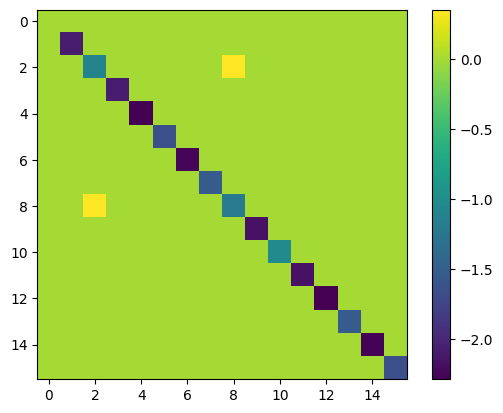

In [56]:
plt.imshow(np.real(R_refKiteTFG.toarray()[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

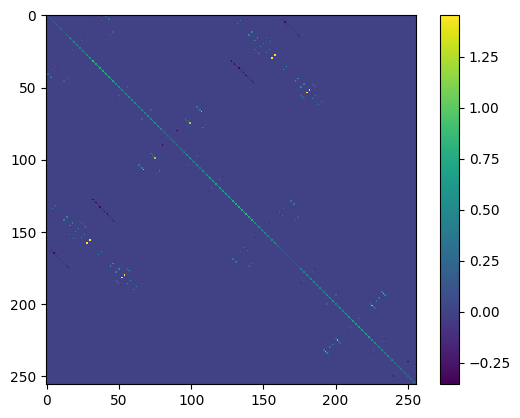

In [64]:
plt.imshow(np.real(R_anTFG-R_refKiteTFG), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [66]:
##Trying to understand the difference in oyutcomes...

find_largest_index(np.abs(R_anTFG-R_refKiteTFG))

(30, 156)

In [67]:
R_anTFG[30,156],R_refKiteTFG[30,156]

((1.4568403612016099+0j), (-3.7e-09+0j))

In [71]:
Symb_TFG_basis[30], Symb_TFG_basis[156]

('   S+1 S-2 Sz3', ' Sz0 S+1 S-2  ')

In [76]:
['S0+S3+','S0-S3-'] in filt_jump_ops

True

In [89]:
#MatRepLib(Normbasis_tfg,S_plus(0)*S_plus(3),of.hermitian_conjugated(S_minus(0)*S_minus(3)),n_qubits=4)
linb_chan = Linb_Channel(S_plus(0)*S_plus(3),of.hermitian_conjugated(S_minus(0)*S_minus(3)),Sz(0)*S_plus(1)*S_minus(2))

#linb_chan_sp = of.get_sparse_operator(linb_chan)

InnProd(S_plus(1)*S_minus(2)*Sz(3),linb_chan)


(-0.5+0j)

In [90]:
chem_shifts

[285822.3227972584, 317613.3950253401, 306549.3676785111, 306913.6349604804]

In [ ]:
chem_shifts[0]+chem_shifts[3]-chem_shifts[]

# Alanine damping rates and detunings

In [147]:
# Define the functions for S_plus, S_minus, and Sz
from basis_utils import S_plus, S_minus, Sz, MatRepLib
from openfermion import QubitOperator


In [148]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""


In [225]:
####Loading of externally computed relaxation matrix...
f = open('./data/ALA_Approx_Filt.pk','rb')
dat = pickle.load(f)

R_ala_approx = dat['KiteMat']

##Loading the analytically-generated secular relaxation matrix...
f = open('./data/R_ALA_sec_analytical.pk','rb')
dat = pickle.load(f)
R_ala_sec_an = dat['mat']

loadMat = spio.loadmat('./data/ALA_NOESY_withGradients_kite.mat',squeeze_me=True)

R_refALAKite= loadMat['p']['R'].item()
R_refALAKite=R_refALAKite.toarray()
#R_ala_kite = 


loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)


R_secular = loadMat['p']['R'].item()
R_secular = R_secular.toarray()
H_ala = loadMat['p']['H'].item().toarray()

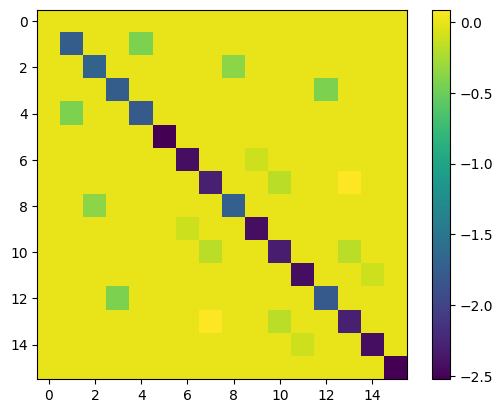

In [216]:
plt.imshow(np.real(R_secular[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

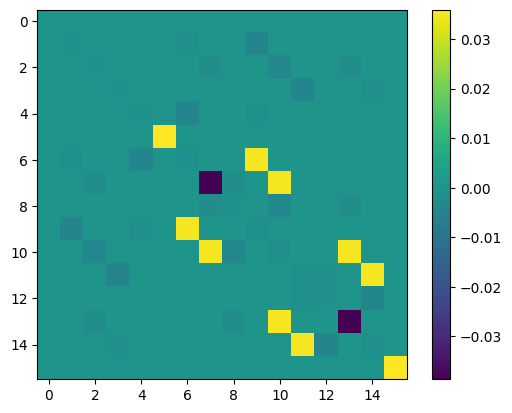

In [215]:
plt.imshow(np.real(R_secular[0:16,0:16]-R_ala_sec_an[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [150]:
savemat('R_ala_approx.mat',{'R_ala_App':R_ala_approx})

In [157]:
data_ala = read_spinach_info(text4)

basis_ala = build_list_ISTs(data_ala)
prefacts,Symb_ALA_basis = build_symbolic_list_ISTs(data_ala)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_ala = NormalizeBasis(basis_ala,n_qubits=4,checkOrth=False)
Normbasis_ala = np.array(Normbasis_ala)

In [152]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8
B0 =14.1
Nspins = 4

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536

freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])

coords = coords*1e-10

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
zeeman_scalar_1 = 3.4938
zeeman_scalar_2 = 1.7947
zeeman_scalar_3 = 1.7947
zeeman_scalar_4 = 1.7947

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaH,B0,zeeman_scalars)

list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)


In [187]:
['S2zS3z','S1zS3z'] in list_jumps

True

In [173]:
np.linalg.norm(np.diag(R_secular)-np.diag(R_ala_approx))

0.08454708045960713

In [192]:
np.linalg.norm(R_refALAKite-R_ala_approx)

5.725972188480124

In [196]:
np.sum(np.abs(np.diag(R_refALAKite)-np.diag(R_ala_approx)))/256

0.004718530513963509

In [193]:
np.linalg.norm(np.diag(R_refALAKite)-np.diag(R_ala_approx))

0.0845470808264419

In [153]:
###Filtering out the jump operators with an associated zero detuning, and construction of the relaxation matrix...
#It is important to keep in mind that for the construction of the relaxation matrix, we need to add the hermitian conjugate of each channel
filt_jump_ops = []
filt_damp_rates = []
for i in range(len(list_dets)):
    if list_dets[i]==0:
        filt_jump_ops.append(list_jumps[i])
        filt_damp_rates.append(list_damp_rates[i])


In [172]:
filt_jump_ops

[['S0+S1+', 'S0-S1-'],
 ['S0-S1-', 'S0+S1+'],
 ['S0zS1+', 'S0zS1-'],
 ['S0zS1-', 'S0zS1+'],
 ['S0+S1z', 'S0-S1z'],
 ['S0-S1z', 'S0+S1z'],
 ['S0zS1z', 'S0zS1z'],
 ['S0+S1-', 'S0-S1+'],
 ['S0-S1+', 'S0+S1-'],
 ['S0+S1+', 'S0-S2-'],
 ['S0-S2-', 'S0+S1+'],
 ['S0zS1+', 'S0zS2-'],
 ['S0zS2-', 'S0zS1+'],
 ['S0+S1z', 'S0-S2z'],
 ['S0-S2z', 'S0+S1z'],
 ['S0zS1z', 'S0zS2z'],
 ['S0+S1-', 'S0-S2+'],
 ['S0-S2+', 'S0+S1-'],
 ['S0+S1+', 'S0-S3-'],
 ['S0-S3-', 'S0+S1+'],
 ['S0zS1+', 'S0zS3-'],
 ['S0zS3-', 'S0zS1+'],
 ['S0+S1z', 'S0-S3z'],
 ['S0-S3z', 'S0+S1z'],
 ['S0zS1z', 'S0zS3z'],
 ['S0+S1-', 'S0-S3+'],
 ['S0-S3+', 'S0+S1-'],
 ['S0zS1+', 'S1zS2-'],
 ['S1zS2-', 'S0zS1+'],
 ['S0zS1+', 'S1-S2z'],
 ['S1-S2z', 'S0zS1+'],
 ['S0zS1z', 'S1zS2z'],
 ['S0zS1z', 'S1-S2+'],
 ['S1-S2+', 'S0zS1z'],
 ['S0zS1+', 'S1zS3-'],
 ['S1zS3-', 'S0zS1+'],
 ['S0zS1+', 'S1-S3z'],
 ['S1-S3z', 'S0zS1+'],
 ['S0zS1z', 'S1zS3z'],
 ['S0zS1z', 'S1-S3+'],
 ['S1-S3+', 'S0zS1z'],
 ['S0zS1+', 'S2zS3-'],
 ['S2zS3-', 'S0zS1+'],
 ['S0zS1+',

In [ ]:
#TODO: verify the quality of matching between the Kite-approximated spectrum and the secular and see what the biggest differences between 

In [159]:
test_rel_ala =RelMat_from_ops_and_rates(filt_jump_ops,filt_damp_rates,Normbasis_ala[0:8],Nspins)


In [171]:
np.linalg.norm(np.diag(R_secular[0:8,0:8])-np.diag(test_rel_ala))

0.002879236925879157

In [167]:
Symb_ALA_basis[4], Symb_ALA_basis[1]

('     S+2  ', '       S+3')

In [144]:
#There are a few channels that we did not include in the computation of the relaxation matrix, because we filtered out channels oscillating exactly at zero, whereas numerically we have
#channels oscillating at frequencies very close to zero, that were filtered out.

#We identify the jump operators that should be included....
add_jump_ops = []
add_damp_rates = []
for i in range(len(list_jumps)):
    if np.abs(list_dets[i])>0.0 and np.abs(list_dets[i])<1e-6:
        add_jump_ops.append(list_jumps[i])
        add_damp_rates.append(list_damp_rates[i])



In [200]:
###Compute the correction to the relaxation matrix....

#correction_R_ala = RelMat_from_ops_and_rates(add_jump_ops,add_damp_rates,Normbasis_ala,Nspins)


In [127]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

             Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0    [S0+S1+, S0-S1-]            0.008624           0.000000
1    [S0-S1-, S0+S1+]            0.008624           0.000000
2    [S0zS1+, S0zS1-]            0.009513           0.000000
3    [S0zS1-, S0zS1+]            0.009513           0.000000
4    [S0+S1z, S0zS1-]            0.009513        6409.059571
..                ...                 ...                ...
679  [S2-S3+, S2zS3z]            0.174166           0.000000
680  [S2+S3-, S2-S3+]            0.043542           0.000000
681  [S2-S3+, S2+S3-]            0.043542           0.000000
682  [S2-S3+, S2-S3+]            0.043542           0.000000
683  [S2-S3+, S2-S3+]            0.043542           0.000000

[684 rows x 3 columns]


In [6]:
list_dets[0]==0.0

True

In [128]:
###Filtering out the jump operators with an associated zero detuning, and construction of the relaxation matrix...
#It is important to keep in mind that for the construction of the relaxation matrix, we need to add the hermitian conjugate of each channel
filt_jump_ops = []
filt_damp_rates = []
for i in range(len(list_dets)):
    if list_dets[i]==0:
        filt_jump_ops.append(list_jumps[i])
        filt_damp_rates.append(list_damp_rates[i])



In [217]:
loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

R_secular = loadMat['p']['R'].item()
H_ala = loadMat['p']['H'].item().toarray()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)



#Parameters taken from Spinach script
tmix = 1.0
dt1 = 0.25e-3
dt2 = 0.25e-3

##Parameters for Fourier transform
zerofill1 = 4096
zerofill2 = 4096


#Calculation of the NOESY spectra using the reference relaxation matrix and the Kite and the jump-operator-truncated approach

Ref_spec = GenNOESYSpectrum(H_ala,R_secular,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Approx_spec = GenNOESYSpectrum(H_ala,R_ala_approx,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Kite_spec = GenNOESYSpectrum(H_ala,R_refALAKite,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Sec_An_spec = GenNOESYSpectrum(H_ala,R_ala_sec_an,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)


In [218]:
Hellinger_2D(Ref_spec,Approx_spec,Tpts1,Tpts2,dt1,dt2)

0.04496905575512669

In [219]:
Hellinger_2D(Ref_spec,Sec_An_spec,Tpts1,Tpts2,dt1,dt2)

0.013655490732371116

In [221]:
Hellinger_2D(Ref_spec,Kite_spec,Tpts1,Tpts2,dt1,dt2)


0.03477831795384649

In [227]:
np.linalg.norm(np.diag(R_ala_approx)-np.diag(R_ala_sec_an))

1.4283037672658028

In [229]:
np.linalg.norm(R_secular-R_ala_sec_an)

3.8369300805827757

In [235]:
####We need to take a closer look to the Hamiltonian parameters...
from simulation_utils import GenH0_Ham, HamMatRep

offset = 1500

Jcoups = np.array([[0.0, 3.822, 3.822, 3.822],
[3.822,0.0,-6.9992,-6.992],
[3.822,-6.9992,0.0,-6.9992],
[3.822,-6.999,-6.9992,0.0]])

An_Ham_ALA = GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaH)

#An_Ham_paulibas = HamMatRep(An_Ham_ALA,Normbasis_ala,n_qubits=4)

In [308]:
#To verify our physical intuition, lets consider how the initial state evolves in time, and whether there is a significant change when approximating the relaxation matrix...
#ala_sec_vals,ala_sec_vecs = np.linalg.eig(H_ala+ R_secular)

#using tmix as a relevant time scale....

#Initrho = expm(-1j*Lx*np.pi/2)@rho0.flatten()
Initrho = rho0.flatten()

t=10/3.822
fin_vec_sec = expm(-1j*(H_ala+R_secular)*t)@Initrho
fin_vec_sec_an =  expm(-1j*(H_ala+R_ala_sec_an)*t)@Initrho
fin_vec_approx = expm(-1j*(H_ala+R_ala_approx)*t)@Initrho



In [309]:
np.linalg.norm(fin_vec_sec-fin_vec_sec_an), np.linalg.norm(fin_vec_sec-fin_vec_approx)#, np.linalg.norm(fin_vec_sec_an-fin_vec_approx)

(0.3167432610833638, 0.21003783871406959)

In [ ]:
#TODO: run spectra generation using a different initial state to prove the hypothesis that results are highly sensitive to the initial state?

In [290]:
np.abs(fin_vec_approx-fin_vec_sec)

array([0.00000000e+00, 0.00000000e+00, 6.25142306e-04, 0.00000000e+00,
       0.00000000e+00, 1.76692104e-27, 0.00000000e+00, 4.06890669e-03,
       1.85284913e-03, 0.00000000e+00, 8.36012417e-03, 0.00000000e+00,
       0.00000000e+00, 4.09146083e-03, 0.00000000e+00, 5.51750174e-27,
       0.00000000e+00, 9.92680060e-28, 0.00000000e+00, 4.10763791e-03,
       6.77150417e-27, 0.00000000e+00, 1.80303478e-25, 0.00000000e+00,
       0.00000000e+00, 2.03179080e-25, 0.00000000e+00, 7.20171000e-03,
       4.12978714e-03, 0.00000000e+00, 8.95507860e-03, 0.00000000e+00,
       1.94124854e-03, 0.00000000e+00, 8.31008294e-03, 0.00000000e+00,
       0.00000000e+00, 1.98871588e-25, 0.00000000e+00, 1.05395138e-02,
       8.30136056e-03, 0.00000000e+00, 6.30721077e-03, 0.00000000e+00,
       0.00000000e+00, 1.05288851e-02, 0.00000000e+00, 1.93547833e-25,
       0.00000000e+00, 4.16020569e-03, 0.00000000e+00, 3.28969066e-27,
       4.15558813e-03, 0.00000000e+00, 8.96275788e-03, 0.00000000e+00,
      

In [239]:
#np.linalg.norm(ala_sec_vecs@np.diag(ala_sec_vals)@np.linalg.inv(ala_sec_vecs)-H_ala- R_secular)

3.6754470560348324e-10

array([0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [287]:
Symb_ALA_basis[2], Symb_ALA_basis[8], Symb_ALA_basis[32], Symb_ALA_basis[128]

('       Sz3', '     Sz2  ', '   Sz1    ', ' Sz0      ')

In [263]:
np.argsort(np.abs(np.linalg.inv(ala_sec_vecs)@rho0.flatten()))

array([255, 253, 254,  36, 139, 125,   5,  75,   1,  11,  89,  62,   0,
       197, 200,  35,  14, 190,  13,  51,  61,  82,  66,  63,   3,   2,
       210,  65, 136, 213, 195, 102,   7,  31,  64,   6, 101, 108,  88,
        70, 116, 207, 172, 182, 131, 133,   4, 174, 100,  43, 117,  96,
       110, 107, 124, 185, 183, 153, 170, 191,   8, 157, 189, 194, 109,
        47,  30, 211,  91, 205, 115, 111,  77,  90, 196, 203,  93,   9,
        74,  15,  92, 104, 130,  94, 171, 154,  79,  72, 141,  12, 143,
       178,  86, 142,  99,  60, 106, 152,  10,  95,  81,  48, 161,  44,
        46, 155, 132,  97, 105, 202, 137, 209, 163, 176, 129, 193, 103,
       147, 144,  76,  68, 113, 175,  69,  71,  85,  45, 199, 206, 198,
       114, 122, 112, 140, 146, 204,  80, 184, 167,  87, 166, 208,  98,
        16, 212, 177, 135,  83, 156, 179,  67,  17,  78,  73, 149, 148,
       160, 151, 158, 138,  84,  52, 186, 187, 180, 134, 201, 181, 123,
       127, 188, 150, 192, 126, 118, 169, 145, 119, 173, 128, 16

In [265]:
###Taking a closer look to the eigenbasis...
np.argsort(np.abs(ala_sec_vecs[:,235]))

array([  0,  85, 255, 190, 115,  21,  87, 253,  44,  55, 252,  61,  92,
       202, 200, 197,   4,  53, 117, 209,  56, 237,  60, 234, 213, 131,
       217,  66, 226, 127, 207,  38, 106, 171, 229, 242,  29, 164, 143,
       212, 124, 246, 144,  47, 159, 188, 151, 175, 222,  71,  22, 134,
       149, 103, 254,  82, 105, 204, 116,  63, 123, 205, 129,  37, 140,
        79,  83, 157,  17, 183,   6, 211, 148,   5, 247, 187, 150,  72,
        74, 111, 192,  98,  94, 104, 231, 126,  64,  59, 133, 239, 118,
       249,  20, 214, 224, 153,   9, 109, 232,  15, 166,  51,  31, 174,
        50,  77,  43, 219, 238, 142,  86,  91, 121, 165, 243,   3, 179,
       100, 184, 195,  81, 132, 194, 223, 227,  25, 145, 113, 244, 101,
        58,  62,  69, 137,  24,  41, 163, 241,  48, 248,  26, 251,  89,
        46,  18,  96, 191, 102,  11,   1, 186, 220,  36, 199, 181,  65,
       178, 139, 152, 240,  88, 172, 154, 189,  68, 161,  23, 236, 176,
       169,  33, 146,  12,  16,  14, 206,  35, 250,  90,  84,  9

In [281]:
Symb_ALA_basis[8], Symb_ALA_basis[2], Symb_ALA_basis[32], Symb_ALA_basis[42], Symb_ALA_basis[57]

('     Sz2  ', '       Sz3', '   Sz1    ', '   Sz1 Sz2 Sz3', '   S-1 Sz2 S+3')

In [282]:
ala_sec_vecs[:,235][57]

(0.20917109537576473+0j)

In [266]:
chg_rho0 = np.linalg.inv(ala_sec_vecs)@rho0.flatten()

In [271]:
chg_rho0[237]

(-0.0956505006856721+0j)

In [250]:
chg_rho0[235]

(0.6733620594678217+0j)

# The DFG case

In [42]:
loadMat = spio.loadmat('./data/DFG_kite.mat',squeeze_me=True)

R_refKite= loadMat['p']['R'].item()
H_refKite = loadMat['p']['H'].item()

In [43]:
###Analytically generated ZZ-terms,
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""


gammaF = 251814800
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10

coords = np.array([coord1,coord2])
w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])

tc =  0.5255e-9
Nspins = 2 

data = read_spinach_info(text)

basis = build_list_ISTs(data)

Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)

In [5]:
R_kite_dev = KiteRelMatrixMany(2*np.pi*freqs,tc,coords,Nspins,gammaF,Normbasis)
R_kite_approx = ApproxKiteMany(2*np.pi*freqs,tc,coords,Nspins,gammaF,Normbasis)

Finished computing the K2 type contributions
Finished computing the K1 type contributions
Finished computing the K0 type contributions
Finished computing the K1 type contributions
Finished computing the K0 type contributions


In [6]:
np.linalg.norm(R_refKite-R_kite_dev)

0.0017873835640859778

In [7]:
np.linalg.norm(R_refKite-R_kite_approx)

0.6459184908148382

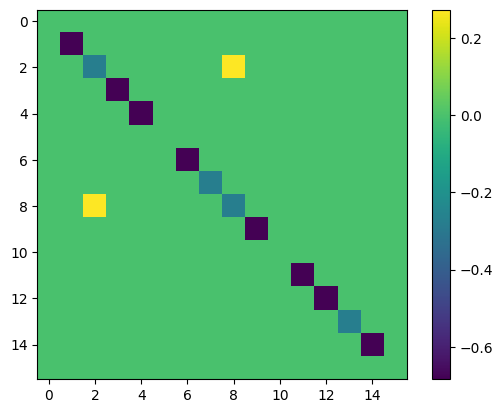

In [9]:
plt.imshow(np.real(R_kite_approx), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

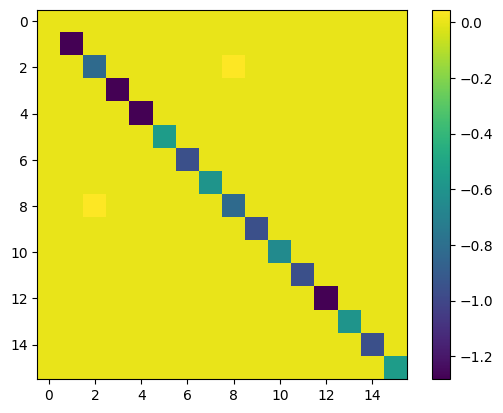

In [6]:
plt.imshow(np.real(R_kite_dev), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [8]:
np.linalg.norm(R_refKite-R_kite_dev)

0.0017873835640859778

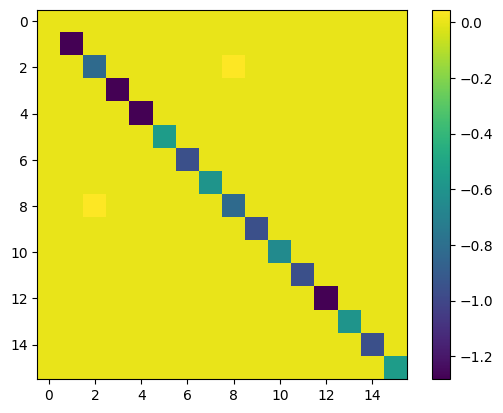

In [9]:
plt.imshow(np.real(R_refKite), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

# Checking the 4 spin case

In [8]:
import pickle

In [9]:
loadMat = spio.loadmat('./data/ALA_NOESY_withGradients_kite.mat',squeeze_me=True)

R_refALAKite= loadMat['p']['R'].item()
R_refALAKite=R_refALAKite.toarray()
H_refALAKite = loadMat['p']['H'].item()

In [10]:
f = open('./data/ALA_Analytical_Kite.pk','rb')
data = pickle.load(f)

ALA_Analytical_Kite = data['KiteMat']

In [11]:
#Collecting off-diagonal indexes....

Ref_Kite_offidxs = []
AN_Kite_offdixs = []

for i in range(256):
    for j in range(i+1,256):
        if np.abs(R_refALAKite[i,j])!=0:
            Ref_Kite_offidxs.append([i,j])
        if np.abs(ALA_Analytical_Kite[i,j])!=0:
            AN_Kite_offdixs.append([i,j])

#collect all the indexes that are not in the reference...

Extra_offidxs_ALA = []
for idx in AN_Kite_offdixs:
    if idx not in Ref_Kite_offidxs:
        Extra_offidxs_ALA.append(idx)



In [18]:
sum_off = 0.0

list_off_values = []
for idx in Extra_offidxs_ALA:
    sum_off+=np.abs(ALA_Analytical_Kite[idx[0],idx[1]])
    list_off_values.append(ALA_Analytical_Kite[idx[0],idx[1]])


In [36]:
diff=0.0
for i in range(256):
    diff+=np.abs(R_refALAKite[i,i]-ALA_Analytical_Kite[i,i])


In [38]:
diff/256

0.06425369883525303

In [39]:
np.diag(R_refALAKite)

array([ 0.        +0.j, -1.74919009+0.j, -1.68958886+0.j, -1.74919009+0.j,
       -1.78472988+0.j, -2.52290813+0.j, -2.42520965+0.j, -2.29450392+0.j,
       -1.7239392 +0.j, -2.42399897+0.j, -2.32450054+0.j, -2.42399897+0.j,
       -1.78472988+0.j, -2.29450392+0.j, -2.42520965+0.j, -2.52290813+0.j,
       -1.69609165+0.j, -2.43466071+0.j, -2.35168549+0.j, -2.2378731 +0.j,
       -2.44382745+0.j, -2.39809851+0.j, -2.10809152+0.j, -1.65709032+0.j,
       -2.33725378+0.j, -2.09468537+0.j, -1.9038369 +0.j, -1.76197844+0.j,
       -2.19515167+0.j, -1.62953743+0.j, -1.74391787+0.j, -1.65333307+0.j,
       -1.63832069+0.j, -2.35350966+0.j, -2.25454433+0.j, -2.35350966+0.j,
       -2.34028862+0.j, -2.1091586 +0.j, -1.90741754+0.j, -1.75140322+0.j,
       -2.23824941+0.j, -1.90433717+0.j, -1.76544553+0.j, -1.90433717+0.j,
       -2.34028862+0.j, -1.75140322+0.j, -1.90741754+0.j, -2.1091586 +0.j,
       -1.69609165+0.j, -2.2378731 +0.j, -2.35168549+0.j, -2.43466071+0.j,
       -2.19515167+0.j, -

In [35]:
np.linalg.norm(np.diag(ALA_Analytical_Kite)-np.diag(R_refALAKite))

1.6486728558822372

In [33]:
np.sum(np.abs(list_off_values))/len(list_off_values)

0.03513270827257491

In [34]:
np.sum(np.abs(np.diag(ALA_Analytical_Kite)))/256

2.030772637636818

In [31]:
Symb_ALA_basis[73], Symb_ALA_basis[97]

(' S+0   Sz2 S+3', ' S+0 Sz1   S+3')

In [24]:
ALA_Analytical_Kite[73,97]

(-0.38220176938405204+0j)

In [21]:
np.argmax(np.abs(list_off_values))

91

In [22]:
list_off_values[91]

(-0.38220176938405204+0j)

In [71]:
Symb_ALA_basis[8], Symb_ALA_basis[128]

('     Sz2  ', ' Sz0      ')

In [74]:
Symb_ALA_basis[6], Symb_ALA_basis[36]

('     S+2 Sz3', '   Sz1 S+2  ')

In [80]:
from openfermion import QubitOperator
from basis_utils import S_plus,S_minus,Sz,InnProd


def AN_Lib(rho,A,B):
    return A*rho*B-0.5*(A*B*rho+rho*A*B)

A = S_plus(1) * S_plus(3)
B = S_minus(1)*S_minus(3)

rho = Sz(1)*S_plus(2)


#AN_Lib(rho,A,B)

InnProd(Sz(3)*S_plus(2),AN_Lib(rho,B,A),n_qubits=4)

(-1+0j)

In [48]:
InnProd(Op1,Op2,n_qubits=None)

[[6, 36],
 [6, 132],
 [9, 33],
 [9, 129],
 [11, 35],
 [11, 131],
 [14, 44],
 [14, 140],
 [18, 24],
 [18, 144],
 [21, 23],
 [21, 29],
 [21, 31],
 [21, 53],
 [21, 55],
 [21, 61],
 [21, 63],
 [22, 148],
 [23, 29],
 [23, 31],
 [23, 53],
 [23, 55],
 [23, 61],
 [23, 63],
 [24, 144],
 [25, 145],
 [26, 146],
 [26, 152],
 [27, 147],
 [29, 31],
 [29, 53],
 [29, 55],
 [29, 61],
 [29, 63],
 [30, 156],
 [31, 53],
 [31, 55],
 [31, 61],
 [31, 63],
 [33, 129],
 [35, 131],
 [36, 132],
 [37, 133],
 [38, 134],
 [38, 164],
 [39, 135],
 [41, 137],
 [41, 161],
 [43, 139],
 [43, 163],
 [44, 140],
 [45, 141],
 [46, 142],
 [46, 172],
 [47, 143],
 [50, 56],
 [50, 176],
 [53, 55],
 [53, 61],
 [53, 63],
 [53, 181],
 [54, 180],
 [55, 61],
 [55, 63],
 [55, 183],
 [56, 176],
 [57, 177],
 [58, 178],
 [58, 184],
 [59, 179],
 [61, 63],
 [61, 189],
 [62, 188],
 [63, 191],
 [66, 72],
 [66, 96],
 [69, 71],
 [69, 77],
 [69, 79],
 [69, 197],
 [69, 199],
 [69, 205],
 [69, 207],
 [70, 100],
 [71, 77],
 [71, 79],
 [71, 197],
 

In [44]:
len(AN_Kite_offdixs)

444

In [46]:
[2,8] in Ref_Kite_offidxs

True

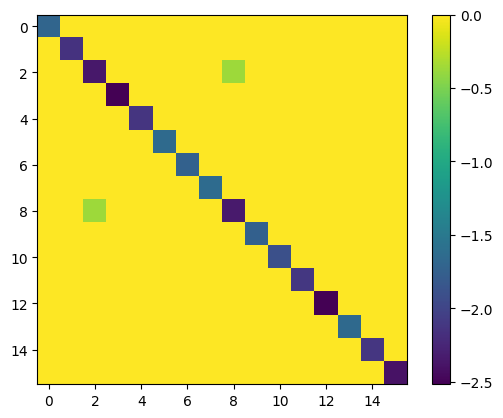

In [40]:
init =48 
fin = 64

plt.imshow(np.real(ALA_Analytical_Kite[init:fin,init:fin]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

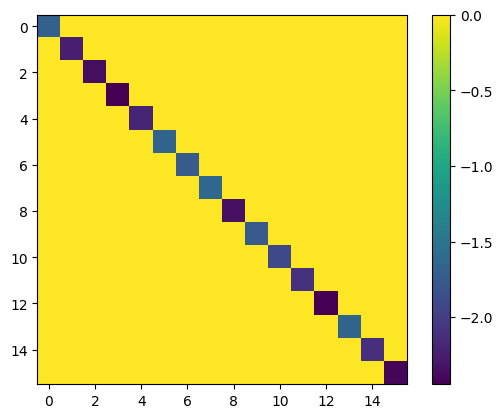

In [41]:
plt.imshow(np.real(R_refALAKite[init:fin,init:fin]), cmap='viridis', interpolation='nearest')
# Add a color bar to show the scale
plt.colorbar()

In [26]:
np.linalg.norm(ALA_Analytical_Kite)

33.30238499387605

In [ ]:
#Load the analytically generated Kite matrix:
loadMat = spio.loadmat('./data/ALA_Analytical_Kite.pk')

In [19]:
np.linalg.norm(R_refALAKite)

33.21719025949559

In [25]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""


In [26]:
data_ala = read_spinach_info(text4)

basis_ala = build_list_ISTs(data_ala)
prefacts,Symb_ALA_basis = build_symbolic_list_ISTs(data_ala)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_ala = NormalizeBasis(basis_ala,n_qubits=4,checkOrth=False)

In [13]:
###Testing a sub-matrix...

Sub_norm_basis = np.copy(Normbasis_ala[0:16])


In [28]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536


freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])

coords = coords*1e-10

Nspins = 4

#R_kiteALA_dev = Kite_relMat(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
#R_kite_dev = KiteRelMatrixMany(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
rates_ALA,JOps_ALA,Symb_JOps_ALA = Get_RatesAndOps(2*np.pi*freqs,tc,coords,Nspins,gammaH)

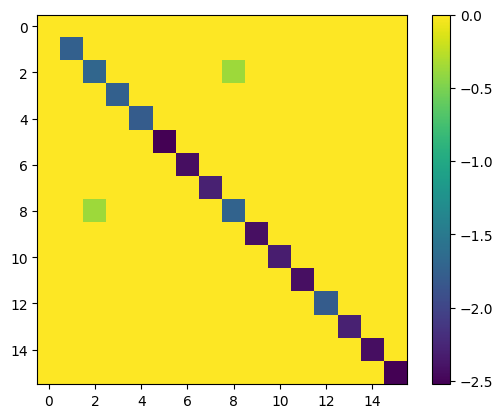

In [14]:
plt.imshow(np.real(R_refALAKite[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to show the scale
plt.colorbar()

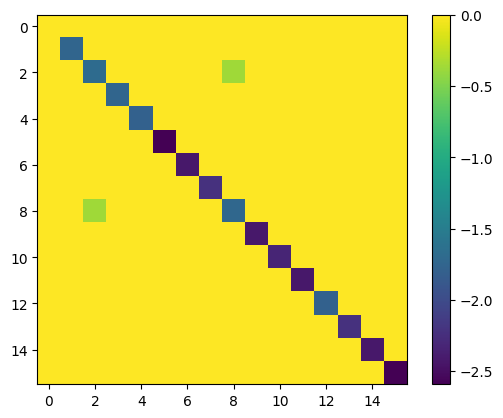

In [16]:
plt.imshow(np.real(R_kite_dev), cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()


In [17]:
np.linalg.norm(R_kite_dev-R_refALAKite[0:16,0:16]) # a good match nbetween the analytically generated Kite matrix and the reference SPinach kite matrix

0.1422004244994652